Classification, detection and segmentation of unordered 3D point sets

In [1]:
import os
import glob
import trimesh

import numpy as np
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [2]:
physical_devices = tf.config.list_physical_devices('GPU')
try:
  tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
  print("Invalid device or cannot modify virtual devices once initialized.")

In [3]:
DATA_DIR = tf.keras.utils.get_file(
    "modelnet.zip",
    "http://3dvision.princeton.edu/projects/2014/3DShapeNets/ModelNet10.zip",
    extract = True,
)

DATA_DIR = os.path.join(os.path.dirname(DATA_DIR), "ModelNet10")

In [4]:
mesh = trimesh.load(os.path.join(DATA_DIR, "chair/train/chair_0001.off"))
mesh.show()

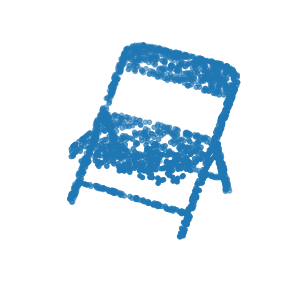

In [5]:
# convert to point cloud

# number of points
points = mesh.sample(2048)

fig = plt.figure(figsize = (5, 5))
ax = fig.add_subplot(111, projection = "3d")
ax.scatter(points[:, 0], points[:, 1], points[:, 2])
ax.set_axis_off()
plt.show()

In [6]:
def parse_dataset(num_points = 2048):

    train_points = []
    train_labels = []
    test_points = []
    test_labels = []
    class_map = {}
    folders = glob.glob(os.path.join(DATA_DIR, "[!README]*"))

    for i, folder in enumerate(folders):
        print("processing class: {}".format(os.path.basename(folder)))
        # store folder name with ID so we can retrieve later
        class_map[i] = folder.split("/")[-1]
        # gather all files
        train_files = glob.glob(os.path.join(folder, "train/*"))
        test_files = glob.glob(os.path.join(folder, "test/*"))

        for f in train_files:
            train_points.append(trimesh.load(f).sample(num_points))
            train_labels.append(i)

        for f in test_files:
            test_points.append(trimesh.load(f).sample(num_points))
            test_labels.append(i)

    return (
        np.array(train_points),
        np.array(test_points),
        np.array(train_labels),
        np.array(test_labels),
        class_map,
    )

In [7]:
NUM_POINTS = 2048
NUM_CLASSES = 10
BATCH_SIZE = 32

train_points, test_points, train_labels, test_labels, CLASS_MAP = parse_dataset(
    NUM_POINTS
)

processing class: night_stand
processing class: monitor
processing class: toilet
processing class: dresser
processing class: sofa
processing class: bathtub
processing class: chair
processing class: bed
processing class: desk
processing class: table


In [8]:
def augment(points, label):
    # jitter points
    points += tf.random.uniform(points.shape, -0.005, 0.005, dtype = tf.float64)
    # shuffle points
    points = tf.random.shuffle(points)
    return points, label


train_dataset = tf.data.Dataset.from_tensor_slices((train_points, train_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((test_points, test_labels))

train_dataset = train_dataset.shuffle(len(train_points)).map(augment).batch(BATCH_SIZE)
test_dataset = test_dataset.shuffle(len(test_points)).batch(BATCH_SIZE)

In [9]:
def conv_bn(x, filters):
    x = layers.Conv1D(filters, kernel_size = 1, padding = "valid")(x)
    x = layers.BatchNormalization(momentum = 0.0)(x)
    return layers.Activation("relu")(x)


def dense_bn(x, filters):
    x = layers.Dense(filters)(x)
    x = layers.BatchNormalization(momentum = 0.0)(x)
    return layers.Activation("relu")(x)

PointNet consists of two core components. The primary MLP network, and the transformer net (T-net). The T-net aims to learn an affine transformation matrix by its own mini network. The T-net is used twice. The first time to transform the input features (n, 3) into a canonical representation. The second is an affine transformation for alignment in feature space (n, 3). As per the original paper we constrain the transformation to be close to an orthogonal matrix (i.e. ||X*X^T - I|| = 0).

In [10]:
class OrthogonalRegularizer(keras.regularizers.Regularizer):
    def __init__(self, num_features, l2reg = 0.001):
        self.num_features = num_features
        self.l2reg = l2reg
        self.eye = tf.eye(num_features)

    def __call__(self, x):
        x = tf.reshape(x, (-1, self.num_features, self.num_features))
        xxt = tf.tensordot(x, x, axes = (2, 2))
        xxt = tf.reshape(xxt, (-1, self.num_features, self.num_features))
        return tf.reduce_sum(self.l2reg * tf.square(xxt - self.eye))

In [11]:
def tnet(inputs, num_features):

    # Initalise bias as the indentity matrix
    bias = keras.initializers.Constant(np.eye(num_features).flatten())
    reg = OrthogonalRegularizer(num_features)

    x = conv_bn(inputs, 32)
    x = conv_bn(x, 64)
    x = conv_bn(x, 512)
    x = layers.GlobalMaxPooling1D()(x)
    x = dense_bn(x, 256)
    x = dense_bn(x, 128)
    x = layers.Dense(
        num_features * num_features,
        kernel_initializer = "zeros",
        bias_initializer = bias,
        activity_regularizer = reg,
    )(x)
    feat_T = layers.Reshape((num_features, num_features))(x)
    # Apply affine transformation to input features
    return layers.Dot(axes = (2, 1))([inputs, feat_T])

In [12]:
inputs = keras.Input(shape = (NUM_POINTS, 3))

x = tnet(inputs, 3)
x = conv_bn(x, 32)
x = conv_bn(x, 32)
x = tnet(x, 32)
x = conv_bn(x, 32)
x = conv_bn(x, 64)
x = conv_bn(x, 512)
x = layers.GlobalMaxPooling1D()(x)
x = dense_bn(x, 256)
x = layers.Dropout(0.3)(x)
x = dense_bn(x, 128)
x = layers.Dropout(0.3)(x)

outputs = layers.Dense(NUM_CLASSES, activation = "softmax")(x)

model = keras.Model(inputs = inputs, outputs = outputs, name = "pointnet")
model.summary()

Model: "pointnet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 2048, 3)]    0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 2048, 32)     128         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 2048, 32)     128         conv1d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 2048, 32)     0           batch_normalization[0][0]        
___________________________________________________________________________________________

In [13]:
model.compile(
    loss = "sparse_categorical_crossentropy",
    optimizer = keras.optimizers.Adam(learning_rate = 0.001),
    metrics = ["sparse_categorical_accuracy"],
)

model.fit(train_dataset, epochs = 20, validation_data = test_dataset)

Epoch 1/20
125/125 [==============================] - 22s 179ms/step - loss: 3.5455 - sparse_categorical_accuracy: 0.2904 - val_loss: 659.0950 - val_sparse_categorical_accuracy: 0.2015
Epoch 2/20
125/125 [==============================] - 16s 129ms/step - loss: 3.0205 - sparse_categorical_accuracy: 0.3721 - val_loss: 182752747955532333056.0000 - val_sparse_categorical_accuracy: 0.2775
Epoch 3/20
125/125 [==============================] - 16s 129ms/step - loss: 2.8714 - sparse_categorical_accuracy: 0.4197 - val_loss: 11794650234880.0000 - val_sparse_categorical_accuracy: 0.3293
Epoch 4/20
125/125 [==============================] - 16s 129ms/step - loss: 2.8131 - sparse_categorical_accuracy: 0.4397 - val_loss: 755550.3125 - val_sparse_categorical_accuracy: 0.2632
Epoch 5/20
125/125 [==============================] - 16s 130ms/step - loss: 2.6547 - sparse_categorical_accuracy: 0.4713 - val_loss: 107385852616417214464.0000 - val_sparse_categorical_accuracy: 0.4020
Epoch 6/20
125/125 [=====

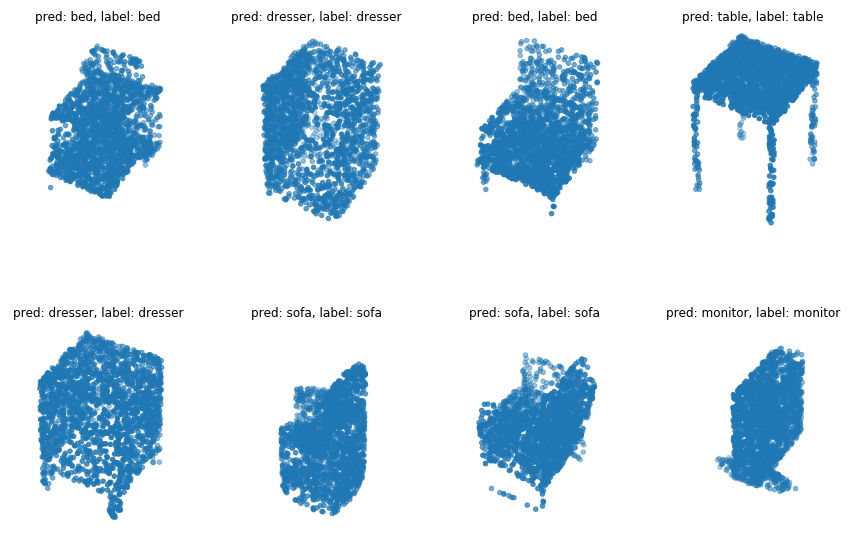

In [14]:
data = test_dataset.take(1)

points, labels = list(data)[0]
points = points[:8, ...]
labels = labels[:8, ...]

# run test data through model
preds = model.predict(points)
preds = tf.math.argmax(preds, -1)

points = points.numpy()

# plot points with predicted class and label
fig = plt.figure(figsize = (15, 10))
for i in range(8):
    ax = fig.add_subplot(2, 4, i + 1, projection = "3d")
    ax.scatter(points[i, :, 0], points[i, :, 1], points[i, :, 2])
    ax.set_title(
        "pred: {:}, label: {:}".format(
            CLASS_MAP[preds[i].numpy()], CLASS_MAP[labels.numpy()[i]]
        )
    )
    ax.set_axis_off()
plt.show()